# Training and Testing 

In [ ]:
import tensorflow as tf
import ants
import voxelmorph as vxm
import neurite as ne
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib
import random
from tensorflow.keras.losses import Loss
from voxelmorph import utils as vxm_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
from scipy.stats import sem


In [15]:
# Check if GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU available")
    # Set memory growth to avoid allocation errors
    for device in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU not available")

GPU available


Lets Load the pretrained model and inspect its layers 

In [3]:
model = vxm.networks.VxmDense.load('C:/Users/lcheu/Documents/BMEN4460_Project/vxm_dense_brain_T1_3D_mse.h5')
print("Expected input shape:", model.input_shape) #see the expected input shape

c:\Users\lcheu\Documents\BMEN4460_Project\venv\lib\site-packages\voxelmorph\tf\networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
c:\Users\lcheu\Documents\BMEN4460_Project\venv\lib\site-packages\voxelmorph\tf\networks.py:129: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


Expected input shape: [(None, 160, 192, 224, 1), (None, 160, 192, 224, 1)]


The model takes in pair of images (moving and fixed, 160x192x224x1). Since our data is not of this size, we must resample to match the shape of the pretrained model

In [ ]:

# Define input/output directories
input_dir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/normalized"
output_dir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled"
os.makedirs(output_dir, exist_ok=False)

# Define the target shape
target_shape = (160, 192, 224)

# Get list of NIfTI files in the input directory
nifti_files = [f for f in os.listdir(input_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

# Loop through each subject and resample
for i, filename in enumerate(nifti_files):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, f"resampled_{filename}")
    
    # Read the MRI image
    image = ants.image_read(input_path)

    # Resample the image to the target shape
    resampled_image = ants.resample_image(image, target_shape, use_voxels=True, interp_type=0) #linear interpolation
    
    # Save the resampled image
    resampled_image.to_file(output_path)
    
    # Print progress
    print(f"Resampled {filename} and saved to {output_path}")

print("Resampling complete for all subjects.")


Resampled normalized_aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz and saved to Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled\resampled_normalized_aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
Resampled normalized_aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz and saved to Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled\resampled_normalized_aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
Resampled normalized_aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz and saved to Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled\resampled_normalized_aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz
Resampled normali

In [6]:
#Define the directory with subject scans
train_subdir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled"
count = 0
# Loop through all subject NIfTI files
for filename in os.listdir(train_subdir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        count += 1
        file_path = os.path.join(train_subdir, filename)
        img = nib.load(file_path)
        print(f"{filename}: {img.shape}")  # Check the shape of each image

print(count)

resampled_normalized_aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210713_155634_RetromerSRA_PD_hom_g2_04_ID428_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210713_170038_RetromerSRA_Sorla_het_g2_01_ID531_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210714_160840_RetromerSRA_Sorla_hom_g3_01_ID532_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normalized_aligned_skstrip_biascorr_20210716_151953_RetromerSRA_Sorla_het_g2_02_ID527_het_TP1_1_1_iso60_WB_mean.nii.gz: (160, 192, 224)
resampled_normal

Let's resample the template image 

In [ ]:
# Define input/output directories
input_dir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_normalized"
output_dir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled"
os.makedirs(output_dir, exist_ok=False)

# Define the target shape
target_shape = (160, 192, 224)

# Get list of NIfTI files in the input directory
nifti_files = [f for f in os.listdir(input_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

# Loop through each subject and resample
for i, filename in enumerate(nifti_files):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, f"resampled_{filename}")
    
    # Read the MRI image
    image = ants.image_read(input_path)

    # Resample the image to the target shape
    resampled_image = ants.resample_image(image, target_shape, use_voxels=True, interp_type=0) #linear interpolation
    
    # Save the resampled image
    resampled_image.to_file(output_path)
    
    # Print progress
    print(f"Resampled {filename} and saved to {output_path}")

print("Resampling complete for all subjects.")


Resampled normalized_warped_template.nii.gz and saved to Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled\resampled_normalized_warped_template.nii.gz
Resampling complete for all subjects.


In [ ]:
#check the size of the template after resampling 
train_templatedir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled"
count = 0
# Loop through all subject NIfTI files
for filename in os.listdir(train_templatedir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        count += 1
        file_path = os.path.join(train_templatedir, filename)
        img = nib.load(file_path)
        print(f"{filename}: {img.shape}")  # Check the shape of each image

print(count)

resampled_normalized_warped_template.nii.gz: (160, 192, 224)
1


In [ ]:
#check if we need to normalize the data further 
image_folder = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled"

# Loop through all NIfTI files
for fname in sorted(os.listdir(image_folder)):
    if fname.endswith(".nii") or fname.endswith(".nii.gz"):
        img_path = os.path.join(image_folder, fname)
        data = nib.load(img_path).get_fdata()

        min_val = np.min(data)
        max_val = np.max(data)

        print(f"{fname} → min: {min_val:.4f}, max: {max_val:.4f}", end="")

        # Flag any out-of-range values
        if min_val < 0 or max_val > 1.05:
            print(" ⚠️  Out of [0, 1] range")
        else:
            print(" ✅ OK")


resampled_normalized_aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9859 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9952 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9768 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210713_155634_RetromerSRA_PD_hom_g2_04_ID428_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9903 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210713_170038_RetromerSRA_Sorla_het_g2_01_ID531_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9867 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210714_160840_RetromerSRA_Sorla_hom_g3_01_ID532_TP1_1_1_iso60_WB_mean.nii.gz → min: 0.0000, max: 0.9873 ✅ OK
resampled_normalized_aligned_skstrip_biascorr_20210716_151953_RetromerSR

In [ ]:
# check if the template needs further normalization 
image_folder = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled"

# Loop through all NIfTI files
for fname in sorted(os.listdir(image_folder)):
    if fname.endswith(".nii") or fname.endswith(".nii.gz"):
        img_path = os.path.join(image_folder, fname)
        data = nib.load(img_path).get_fdata()

        min_val = np.min(data)
        max_val = np.max(data)

        print(f"{fname} → min: {min_val:.4f}, max: {max_val:.4f}", end="")

        # Flag any out-of-range values
        if min_val < 0 or max_val > 1.05:
            print(" ⚠️  Out of [0, 1] range")
        else:
            print(" ✅ OK")


resampled_normalized_warped_template.nii.gz → min: 0.0000, max: 1.0000 ✅ OK


# Finetuned Model

We load the pretrained model provided by Voxel morph and finetune it to adapt to the mouse brain scans 

In [ ]:
# function to split the data / play around with the ratios if data ste if very small 
def split_dataset(moving_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"
    files = [os.path.join(moving_dir, f) for f in os.listdir(moving_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    random.seed(seed)
    random.shuffle(files)
    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]
    return {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

In [ ]:
moving_dir = 'Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/resampled'

#split the dataset 
splits = split_dataset(moving_dir)

In [ ]:
# create a data generator function to give us the appropriate pairs to input the model 
fixed_path = 'Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled/resampled_normalized_warped_template.nii.gz'
pretrained_model_path = 'vxm_dense_brain_T1_3D_mse.h5'

# load fixed image 
fixed_img = nib.load(fixed_path).get_fdata()
fixed_img = fixed_img[np.newaxis, ..., np.newaxis]  # shape: [1, D, H, W, 1]
img_shape = fixed_img.shape[1:4]

def data_generator(file_list):
    while True:
        for path in file_list:
            moving = nib.load(path).get_fdata()
            moving = (moving - moving.min()) / (moving.max() - moving.min())
            moving = moving[np.newaxis, ..., np.newaxis]
            yield ([moving, fixed_img], fixed_img)

We will try 3 different loss functions to see which will get us the best performing model 

Finetune using the MSE loss

In [ ]:
#split into train/val/test 
train_gen = data_generator(splits['train'])
val_gen = data_generator(splits['val'])
test_paths = splits['test']

# load the pretrained model via keras 
custom_objects = {
    'VxmDense': vxm.tf.networks.VxmDense,
    'SpatialTransformer': vxm.tf.layers.SpatialTransformer,
    'RescaleTransform': vxm.tf.layers.RescaleTransform,
    'VecInt': vxm.tf.layers.VecInt
}
model = tf.keras.models.load_model(pretrained_model_path, custom_objects=custom_objects, compile=False)

# define our loss function, l2 reg, and lambda 
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
loss_weights = [1.0, 0.05]

#compile the model 
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses,
    loss_weights=loss_weights
)

# train and save the best model 
finetune_history = model.fit(
    train_gen,
    steps_per_epoch=len(splits['train']),
    epochs=20,
    validation_data=val_gen,
    validation_steps=len(splits['val']),
)

model.save('C:/Users/lcheu/Downloads/vxm_mouse_finetuned.h5')


Epoch 1/20
36/36 [==============================] - 31s 569ms/step - loss: 0.0015 - vxm_dense_transformer_loss: 0.0013 - vxm_dense_flow_loss: 0.0046 - val_loss: 0.0014 - val_vxm_dense_transformer_loss: 0.0012 - val_vxm_dense_flow_loss: 0.0031
Epoch 2/20
36/36 [==============================] - 18s 510ms/step - loss: 0.0014 - vxm_dense_transformer_loss: 0.0013 - vxm_dense_flow_loss: 0.0034 - val_loss: 0.0014 - val_vxm_dense_transformer_loss: 0.0012 - val_vxm_dense_flow_loss: 0.0029
Epoch 3/20
36/36 [==============================] - 18s 508ms/step - loss: 0.0014 - vxm_dense_transformer_loss: 0.0012 - vxm_dense_flow_loss: 0.0032 - val_loss: 0.0014 - val_vxm_dense_transformer_loss: 0.0012 - val_vxm_dense_flow_loss: 0.0028
Epoch 4/20
36/36 [==============================] - 18s 509ms/step - loss: 0.0014 - vxm_dense_transformer_loss: 0.0012 - vxm_dense_flow_loss: 0.0031 - val_loss: 0.0014 - val_vxm_dense_transformer_loss: 0.0012 - val_vxm_dense_flow_loss: 0.0028
Epoch 5/20
36/36 [==========

Finetune using the NCC loss

In [ ]:
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
loss_weights = [1.0, 0.05]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses,
    loss_weights=loss_weights
)

finetune_ncc_history = model.fit(
    train_gen,
    steps_per_epoch=len(splits['train']),
    epochs=40,
    validation_data=val_gen,
    validation_steps=len(splits['val']),
)
model.save('C:/Users/lcheu/Downloads/ncc_vxm_mouse_finetuned.h5')

Epoch 1/40
36/36 [==============================] - 42s 826ms/step - loss: -0.8161 - vxm_dense_transformer_loss: -0.8164 - vxm_dense_flow_loss: 0.0053 - val_loss: -0.8286 - val_vxm_dense_transformer_loss: -0.8290 - val_vxm_dense_flow_loss: 0.0071
Epoch 2/40
36/36 [==============================] - 27s 767ms/step - loss: -0.8303 - vxm_dense_transformer_loss: -0.8308 - vxm_dense_flow_loss: 0.0090 - val_loss: -0.8367 - val_vxm_dense_transformer_loss: -0.8372 - val_vxm_dense_flow_loss: 0.0096
Epoch 3/40
36/36 [==============================] - 27s 767ms/step - loss: -0.8353 - vxm_dense_transformer_loss: -0.8358 - vxm_dense_flow_loss: 0.0111 - val_loss: -0.8402 - val_vxm_dense_transformer_loss: -0.8408 - val_vxm_dense_flow_loss: 0.0113
Epoch 4/40
36/36 [==============================] - 27s 767ms/step - loss: -0.8395 - vxm_dense_transformer_loss: -0.8401 - vxm_dense_flow_loss: 0.0132 - val_loss: -0.8432 - val_vxm_dense_transformer_loss: -0.8438 - val_vxm_dense_flow_loss: 0.0134
Epoch 5/40
3

Fine tune using the SSIM loss

Since SSIM loss is only used on 2D images we have to compute SSIM over all the slices per image and average the loss

In [ ]:
class SliceWiseSSIMLoss(tf.keras.losses.Loss):
    def __init__(self, max_val=1.0):
        super().__init__()
        self.max_val = max_val

    def call(self, y_true, y_pred):
        """
        Assumes shape: [B, D, H, W, C]
        Computes SSIM slice-wise along depth (D) and averages over slices.
        """

        # Transpose to [B, H, W, D, C] to slice along D axis
        y_true_t = tf.transpose(y_true, [0, 2, 3, 1, 4])
        y_pred_t = tf.transpose(y_pred, [0, 2, 3, 1, 4])

        # tf.map_fn handles graph scope correctly
        def compute_slice_ssim(slice_pair):
            slice_true, slice_pred = slice_pair
            return tf.image.ssim(slice_true, slice_pred, max_val=self.max_val)

        # Stack batch and slice dimensions: [B*D, H, W, C]
        shape = tf.shape(y_true_t)
        B, H, W, D, C = shape[0], shape[1], shape[2], shape[3], shape[4]

        true_slices = tf.reshape(y_true_t, [B * D, H, W, C])
        pred_slices = tf.reshape(y_pred_t, [B * D, H, W, C])

        ssim_vals = tf.map_fn(
            compute_slice_ssim,
            (true_slices, pred_slices),
            fn_output_signature=tf.float32
        )

        return 1.0 - tf.reduce_mean(ssim_vals)  # SSIM loss


In [ ]:
ssim_loss = SliceWiseSSIMLoss(max_val=1.0)
losses = [ssim_loss, vxm.losses.Grad('l2').loss]
loss_weights = [1.0, 0.1]


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses,
    loss_weights=loss_weights
)

#we do check pointing to save the mosel with the lowest validation loss 
checkpoint_cb = ModelCheckpoint(
    filepath='C:/Users/lcheu/Downloads/ssim_finetune_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False, 
    mode='min',               # save based on lowest val_loss
    verbose=1
)

# we do early stopping so that we dont have to run for many epochs 
early_stop_cb = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=5,              # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)

finetune_ssim_history_= model.fit(
    train_gen,
    steps_per_epoch=len(splits['train']),
    epochs=40,
    validation_data=val_gen,
    validation_steps=len(splits['val']),
    callbacks=[early_stop_cb, checkpoint_cb]
)

Epoch 1/40
36/36 [==============================] - ETA: 0s - loss: 0.0503 - vxm_dense_transformer_loss: 0.0456 - vxm_dense_flow_loss: 0.0476
Epoch 1: val_loss improved from inf to 0.04589, saving model to C:/Users/lcheu/Downloads\ssim_finetune_model.h5
36/36 [==============================] - 51s 1s/step - loss: 0.0503 - vxm_dense_transformer_loss: 0.0456 - vxm_dense_flow_loss: 0.0476 - val_loss: 0.0459 - val_vxm_dense_transformer_loss: 0.0406 - val_vxm_dense_flow_loss: 0.0527
Epoch 2/40
36/36 [==============================] - ETA: 0s - loss: 0.0456 - vxm_dense_transformer_loss: 0.0403 - vxm_dense_flow_loss: 0.0532
Epoch 2: val_loss improved from 0.04589 to 0.04440, saving model to C:/Users/lcheu/Downloads\ssim_finetune_model.h5
36/36 [==============================] - 36s 1s/step - loss: 0.0456 - vxm_dense_transformer_loss: 0.0403 - vxm_dense_flow_loss: 0.0532 - val_loss: 0.0444 - val_vxm_dense_transformer_loss: 0.0392 - val_vxm_dense_flow_loss: 0.0524
Epoch 3/40
36/36 [============

pickle our results

In [ ]:
# Save all histories to a file
with open('training_histories.pkl', 'wb') as f:
    pickle.dump({
        'mse': finetune_history.history,
        'ncc': finetune_ncc_history.history,
        'ssim': finetune_ssim_history_.history
    }, f)

In [ ]:
# Load the training histories back
with open('training_histories.pkl', 'rb') as f:
    histories = pickle.load(f)

# Access like this:
mse_history = histories['mse']
ncc_history = histories['ncc']
ssim_history = histories['ssim']


In [ ]:
mse_history.keys() #see what losses are saved 

dict_keys(['loss', 'vxm_dense_transformer_loss', 'vxm_dense_flow_loss', 'val_loss', 'val_vxm_dense_transformer_loss', 'val_vxm_dense_flow_loss'])

Let's plot the train and validation loss amongst all three models we just tuned

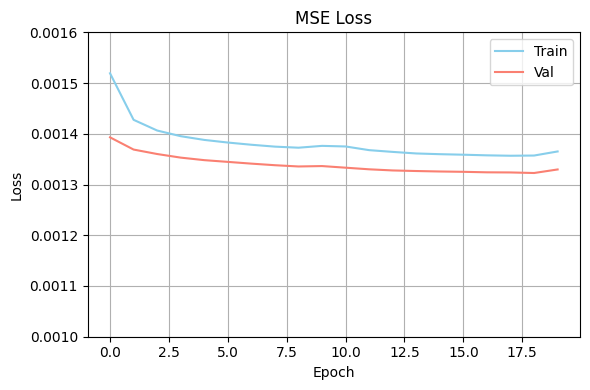

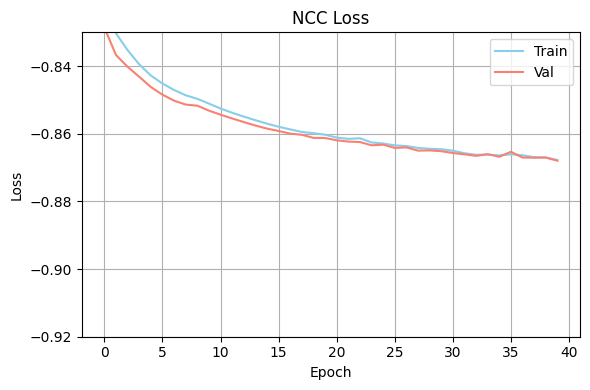

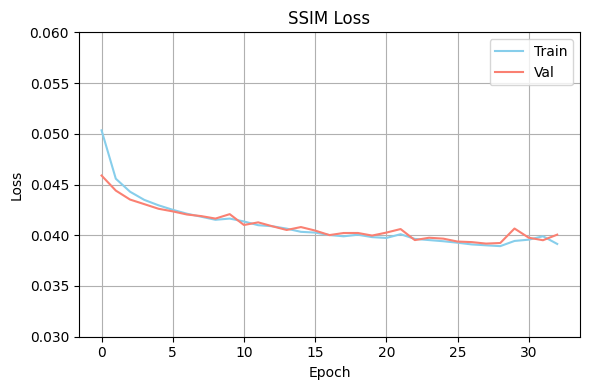

In [ ]:

# === MSE ==
plt.figure(figsize=(6, 4))
plt.plot(mse_history['loss'], label='Train', color='skyblue')
plt.plot(mse_history['val_loss'], label='Val', color='salmon')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.001, 0.0016])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === NCC ===
plt.figure(figsize=(6, 4))
plt.plot(ncc_history['loss'], label='Train', color='skyblue')
plt.plot(ncc_history['val_loss'], label='Val', color='salmon')
plt.title('NCC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-0.92, -0.83])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === SSIM ===
plt.figure(figsize=(6, 4))
plt.plot(ssim_history['loss'], label='Train', color='skyblue')
plt.plot(ssim_history['val_loss'], label='Val', color='salmon')
plt.title('SSIM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.03, 0.06])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Lets visualize on the three models we just finetuned with different loss functions

In [ ]:
# Function to draw deformation grid from displacement field
def draw_deformation_grid(flow_slice, spacing=6):
    h, w = flow_slice.shape[:2]
    x = np.arange(0, w, spacing)
    y = np.arange(0, h, spacing)
    X, Y = np.meshgrid(x, y)
    dx = flow_slice[Y, X, 0]
    dy = flow_slice[Y, X, 1]
    return X + dx, Y + dy

In [ ]:
# Function to convert displacement field to RGB
def displacement_to_rgb(flow_slice):
    norm = Normalize(vmin=-10, vmax=10)  # Adjust range if needed
    r = norm(flow_slice[..., 0])
    g = norm(flow_slice[..., 1])
    b = norm(flow_slice[..., 2])
    return np.clip(np.stack([r, g, b], axis=-1), 0, 1)

In [ ]:
# Function to visualize the results with deformation grid as a separate column
def visualize_results(title, moving, fixed, warped, flow, cmap='gray'):
    slice_idx = 80   # Axial middle slice
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(moving[..., slice_idx], cmap=cmap)
    axs[0].set_title('Moving')

    axs[1].imshow(fixed[..., slice_idx], cmap=cmap)
    axs[1].set_title('Fixed')

    rgb_disp = displacement_to_rgb(flow[..., slice_idx, :])
    axs[2].imshow(rgb_disp)
    axs[2].set_title('Displacement (RGB)')

    axs[3].imshow(warped[..., slice_idx], cmap=cmap)
    axs[3].set_title('Warped')

    # deformation grid 
    flow_slice = flow[..., slice_idx, :]
    X_def, Y_def = draw_deformation_grid(flow_slice, spacing=6)
    axs[4].set_xlim(0, flow_slice.shape[1])
    axs[4].set_ylim(flow_slice.shape[0], 0)
    axs[4].set_title('Deformation Grid')

    for m in range(X_def.shape[0]):
        axs[4].plot(X_def[m, :], Y_def[m, :], 'black', lw=1)
    for n in range(X_def.shape[1]):
        axs[4].plot(X_def[:, n], Y_def[:, n], 'black', lw=1)

    for ax in axs:
        ax.axis('off')

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 3s 3s/step


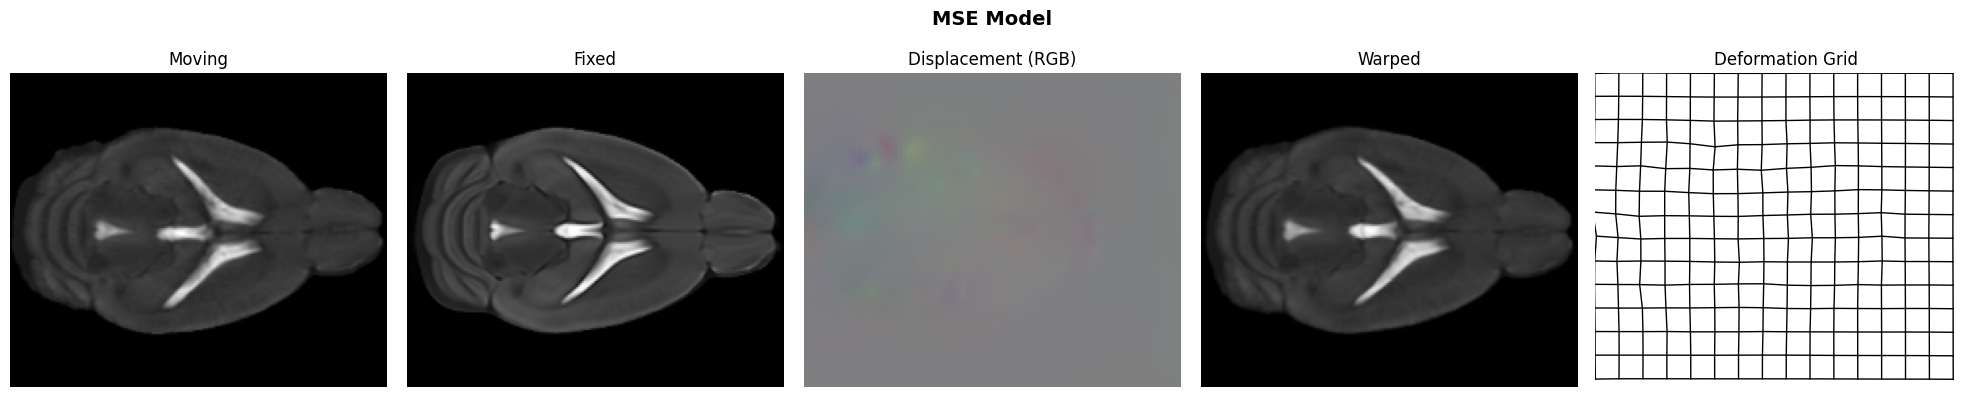

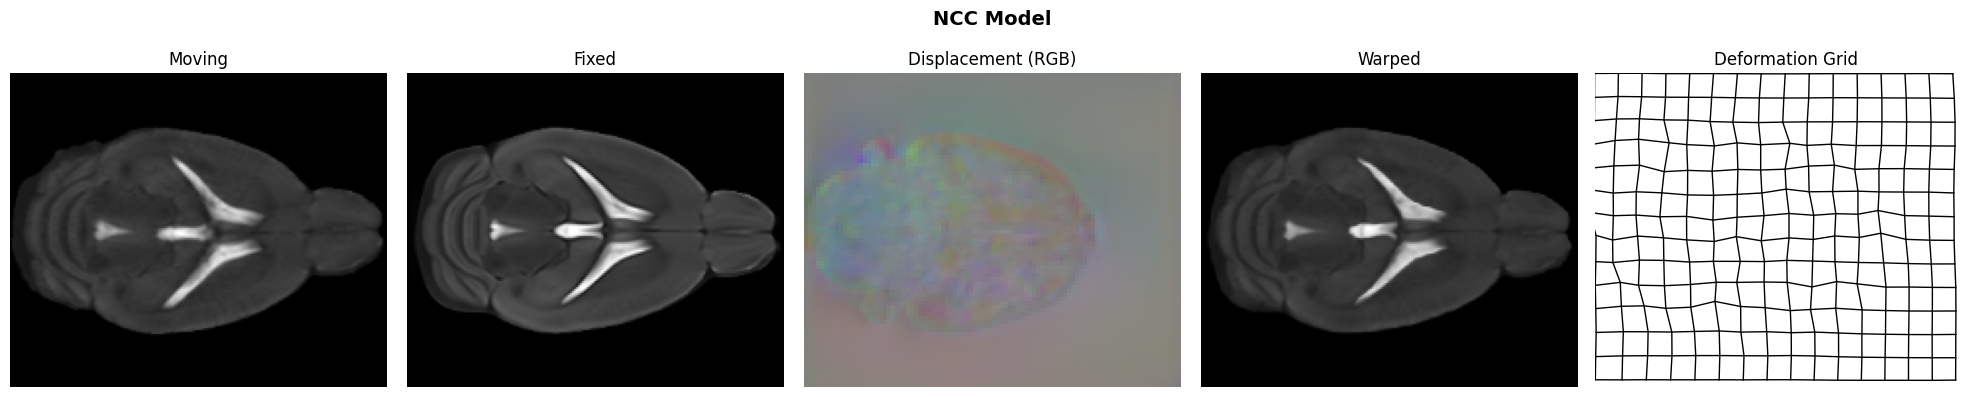

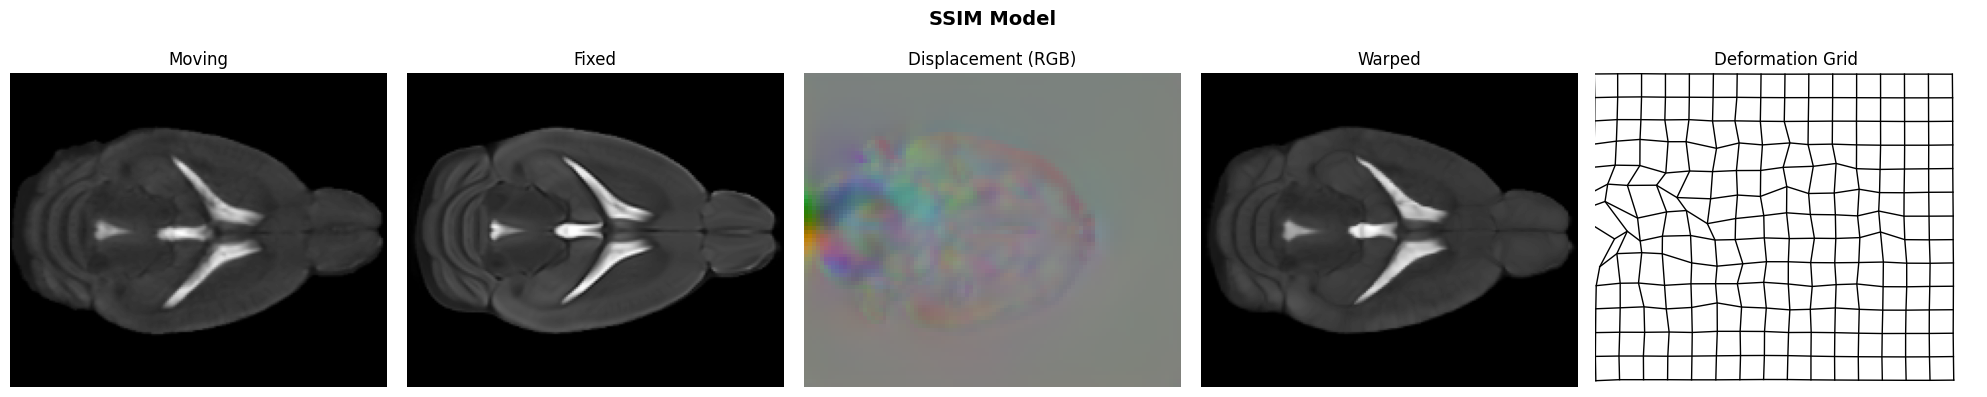

In [ ]:
# load and norm one sample 
random_file = random.choice(splits['train'])
moving_img = nib.load(random_file).get_fdata()
fixed_img = nib.load(fixed_path).get_fdata()

# load model
custom_objects = {'VxmDense': vxm.networks.VxmDense}

model_mse = tf.keras.models.load_model(
    'C:/Users/lcheu/Downloads/vxm_mouse_finetuned.h5',
    compile=False,
    custom_objects=custom_objects
)

model_ncc = tf.keras.models.load_model(
    'C:/Users/lcheu/Downloads/ncc_vxm_mouse_finetuned.h5',
    compile=False,
    custom_objects=custom_objects
)

model_ssim = tf.keras.models.load_model(
    'C:/Users/lcheu/Downloads/ssim_finetune_model.h5',
    compile=False,
    custom_objects=custom_objects
)

# predict and visualize 
moving_input = moving_img[np.newaxis, ..., np.newaxis]
fixed_input = fixed_img[np.newaxis, ..., np.newaxis]

warped_mse, flow_mse = model_mse.predict([moving_input, fixed_input])
warped_ncc, flow_ncc = model_ncc.predict([moving_input, fixed_input])
warped_ssim, flow_ssim = model_ssim.predict([moving_input, fixed_input])

visualize_results('MSE Model', moving_img, fixed_img, warped_mse[0, ..., 0], flow_mse[0])
visualize_results('NCC Model', moving_img, fixed_img, warped_ncc[0, ..., 0], flow_ncc[0])
visualize_results('SSIM Model', moving_img, fixed_img, warped_ssim[0, ..., 0], flow_ssim[0])


Compute Jacobians determinants

In [ ]:
# List all available attributes and methods in vxm_utils to find the jacobian class
print(dir(vxm.py.utils))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'affine_shift_to_matrix', 'clean_seg', 'clean_seg_batch', 'csv', 'default_unet_features', 'dice', 'dist_trf', 'edge_to_surface_pts', 'extract_largest_vol', 'filter_labels', 'functools', 'get_backend', 'get_surface_pts_per_label', 'jacobian_determinant', 'load_labels', 'load_pheno_csv', 'load_volfile', 'measure', 'nd', 'np', 'os', 'pad', 'read_file_list', 'read_pair_list', 'resize', 'save_volfile', 'scipy', 'sdt_to_surface_pts', 'signed_dist_trf', 'vol_to_sdt', 'vol_to_sdt_batch']


In [ ]:
#function to compute the jacobian 
def compute_nonpositive_jacobian(flow):
    # Ensure shape (H, W, D, 3)
    if flow.ndim == 5:
        flow = flow[0]

    # Compute Jacobian determinant volume
    jac = vxm.py.utils.jacobian_determinant(flow)

    # Count non-positive voxels
    num_nonpos = np.sum(jac <= 0)
    total_voxels = np.prod(jac.shape)
    percent_nonpos = (num_nonpos / total_voxels) * 100

    return num_nonpos, percent_nonpos

# Run it on all flows
for name, flow in zip(["MSE", "NCC", "SSIM"], [flow_mse, flow_ncc, flow_ssim]):
    n, p = compute_nonpositive_jacobian(flow)
    print(f"{name}: {n:,} voxels ({p:.2f}%) with non-positive Jacobian determinant")



MSE: 74 voxels (0.01%) with non-positive Jacobian determinant
NCC: 6,950 voxels (0.81%) with non-positive Jacobian determinant
SSIM: 31,145 voxels (3.62%) with non-positive Jacobian determinant


Lets run the test set on the MSE model and the pretrained (no finetuning) model

In [ ]:
# test on the MSE model 
grad_loss = vxm.losses.Grad('l2').loss

# compile the model 
model_mse = tf.keras.models.load_model(
    'C:/Users/lcheu/Downloads/vxm_mouse_finetuned.h5',
    custom_objects={
        'VxmDense': vxm.tf.networks.VxmDense,
        'SpatialTransformer': vxm.tf.layers.SpatialTransformer,
        'RescaleTransform': vxm.tf.layers.RescaleTransform,
        'VecInt': vxm.tf.layers.VecInt
    },
    compile=False
)

model_mse.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=[vxm.losses.MSE().loss, grad_loss],
    loss_weights=[1.0, 0.01]
)

test_gen = data_generator(splits['test'])
test_loss_mse = model_mse.evaluate(test_gen, steps=9)

9/9 [==============================] - 6s 283ms/step - loss: 0.0012 - vxm_dense_transformer_loss: 0.0011 - vxm_dense_flow_loss: 0.0028


In [95]:
print(f"Test Loss (MSE): {test_loss_mse}")

Test Loss (MSE): [0.0011627153726294637, 0.0011349543929100037, 0.0027761063538491726]


In [ ]:
# Test on the pretrained model 
grad_loss = vxm.losses.Grad('l2').loss

pretrained_model = tf.keras.models.load_model(
    "vxm_dense_brain_T1_3D_mse.h5",
    compile=False,
    custom_objects={'VxmDense': vxm.networks.VxmDense}
)

pretrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=[vxm.losses.MSE().loss, grad_loss],
    loss_weights=[1.0, 0.01]
)

In [ ]:
test_loss_pretrained = pretrained_model.evaluate(test_gen, steps=9)
print("Test Loss (Pretrained Model):", test_loss_pretrained)

9/9 [==============================] - 6s 273ms/step - loss: 0.0012 - vxm_dense_transformer_loss: 0.0011 - vxm_dense_flow_loss: 0.0183
Test Loss (Pretrained Model): [0.0012439199490472674, 0.0010608829325065017, 0.018303707242012024]


Lets plot the results and compare using the std, sme, and mean

C:\Users\lcheu\AppData\Local\Temp\ipykernel_20252\3489048627.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Model", y="Loss", data=loss_data, palette="Set2")


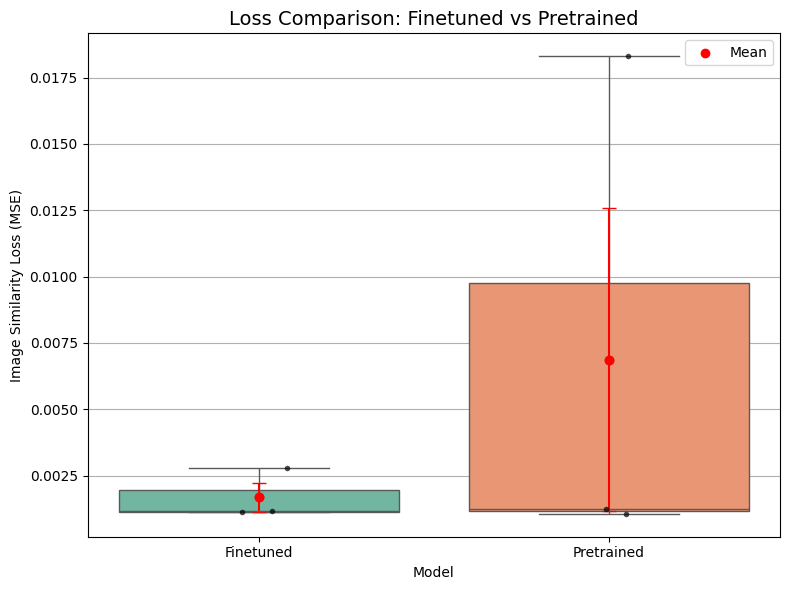

     Model     Mean      Std      SEM
 Finetuned 0.001691 0.000940 0.000542
Pretrained 0.006870 0.009903 0.005717


In [ ]:
# load the data into df 
loss_data = pd.DataFrame({
    "Loss": test_loss_mse + test_loss_pretrained,
    "Model": ["Finetuned"] * len(test_loss_mse) + ["Pretrained"] * len(test_loss_pretrained)
})

#calculate the stats 
group_stats = loss_data.groupby("Model")["Loss"].agg(["mean", "std", sem]).reset_index()
group_stats.columns = ["Model", "Mean", "Std", "SEM"]

# plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Model", y="Loss", data=loss_data, palette="Set2")
sns.stripplot(x="Model", y="Loss", data=loss_data, color='black', size=4, jitter=0.1, alpha=0.7)

for i, row in group_stats.iterrows():
    plt.scatter(i, row["Mean"], color='red', zorder=10, label='Mean' if i == 0 else "")
    plt.errorbar(i, row["Mean"], yerr=row["SEM"], fmt='o', color='red', capsize=5)

plt.title("Loss Comparison: Finetuned vs Pretrained", fontsize=14)
plt.ylabel("Image Similarity Loss (MSE)")
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(group_stats.to_string(index=False))


Let's visualize our results and compare

1/1 [==============================] - 2s 2s/step


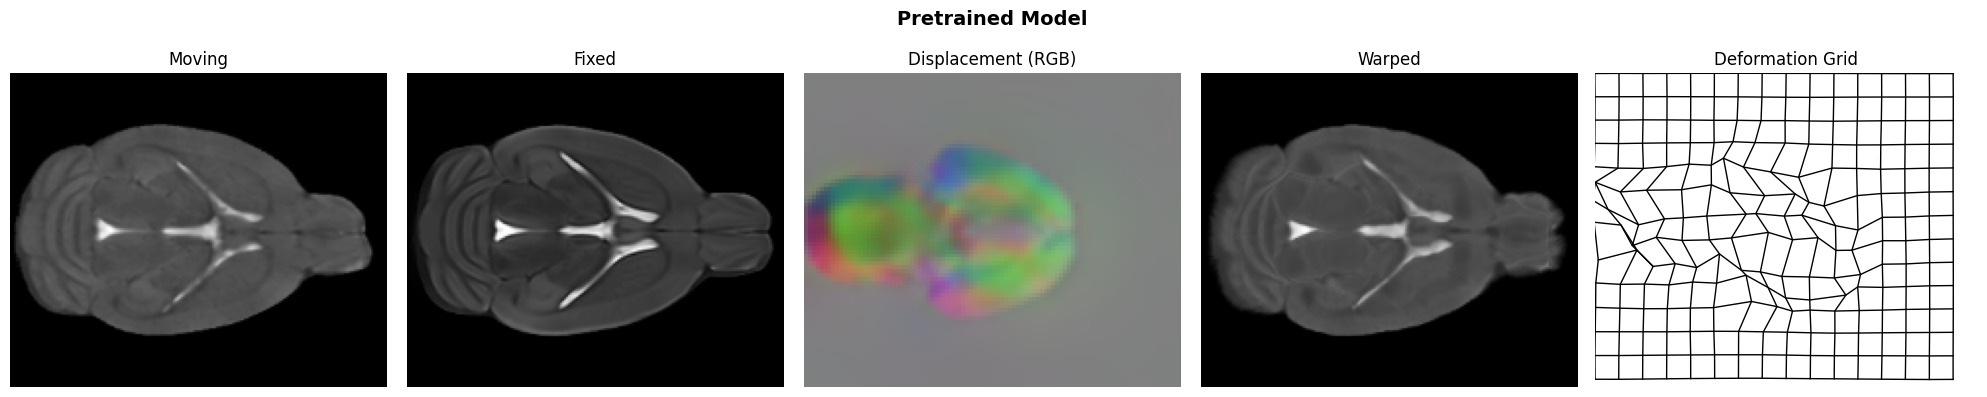

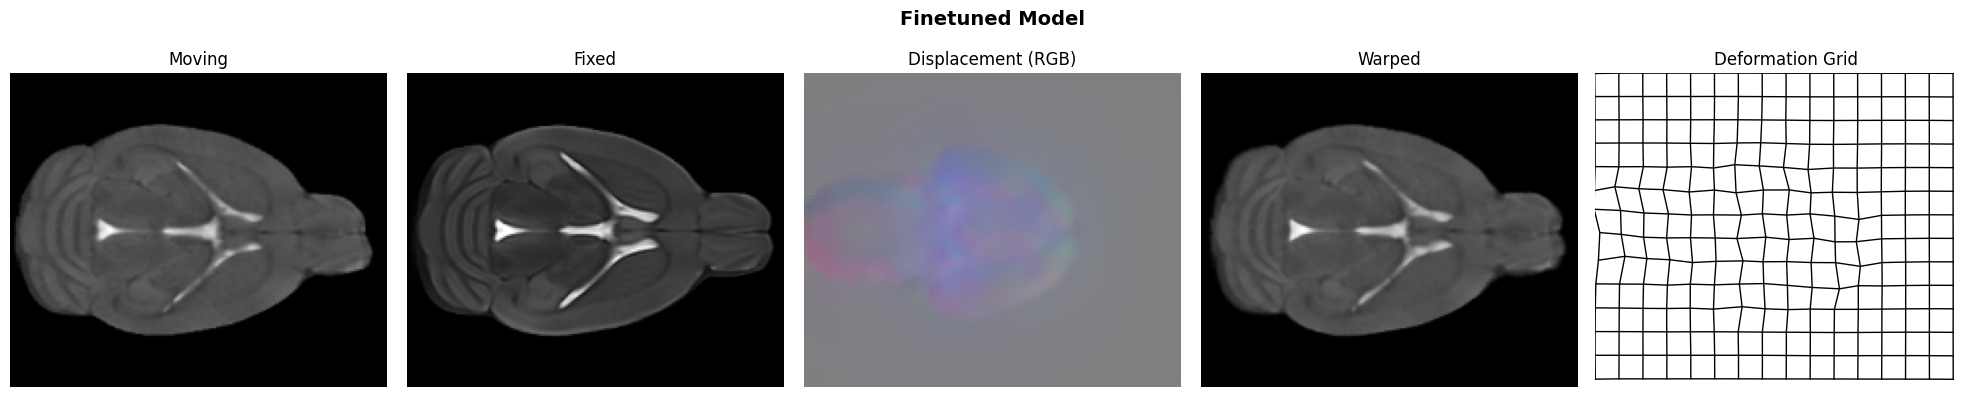

In [ ]:
#choose random subject 
random_file = random.choice(splits['test'])
moving_img = nib.load(random_file).get_fdata()
fixed_img = nib.load(fixed_path).get_fdata()

# load models 
custom_objects = {'VxmDense': vxm.networks.VxmDense}

pretrained = tf.keras.models.load_model(
    'vxm_dense_brain_T1_3D_mse.h5',
    compile=False,
    custom_objects=custom_objects)

pretrained.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=[vxm.losses.MSE().loss, grad_loss],
    loss_weights=[1.0, 0.01]
)

finetuned = tf.keras.models.load_model(
    'C:/Users/lcheu/Downloads/vxm_mouse_finetuned.h5',
    compile=False,
    custom_objects=custom_objects)

finetuned.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=[vxm.losses.MSE().loss, grad_loss],
    loss_weights=[1.0, 0.01]
)

# predict and visualize 
moving_input = moving_img[np.newaxis, ..., np.newaxis]
fixed_input = fixed_img[np.newaxis, ..., np.newaxis]

warped_pretrained, flow_pretrained = pretrained.predict([moving_input, fixed_input])
warped_finetuned, flow_finetuned = finetuned.predict([moving_input, fixed_input])

visualize_results('Pretrained Model', moving_img, fixed_img, warped_pretrained[0, ..., 0], flow_pretrained[0])
visualize_results('Finetuned Model', moving_img, fixed_img, warped_finetuned[0, ..., 0], flow_finetuned[0])


Let's calculate the jacobian 

In [ ]:

def compute_nonpositive_jacobian(flow):
    # Ensure shape (H, W, D, 3)
    if flow.ndim == 5:
        flow = flow[0]

    # Compute Jacobian determinant volume
    jac = vxm.py.utils.jacobian_determinant(flow)

    # Count non-positive voxels
    num_nonpos = np.sum(jac <= 0)
    total_voxels = np.prod(jac.shape)
    percent_nonpos = (num_nonpos / total_voxels) * 100

    return num_nonpos, percent_nonpos

# Run it on all flows
for name, flow in zip(["Pretrained", "Finetuned"], [flow_pretrained, flow_finetuned]):
    n, p = compute_nonpositive_jacobian(flow)
    print(f"{name}: {n:,} voxels ({p:.2f}%) with non-positive Jacobian determinant")



Pretrained: 23,515 voxels (2.73%) with non-positive Jacobian determinant
Finetuned: 780 voxels (0.09%) with non-positive Jacobian determinant


For more comparisons, we plot 3 of the same subjects and slice for both models and the log of the jacobian for better visualzation

In [ ]:
def compute_log_jacobian(flow):
    jac = vxm.py.utils.jacobian_determinant(flow)
    jac[jac <= 0] = 1e-6  # prevent log(0)
    return np.log(jac)

In [ ]:

fixed_path = 'Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/train/template_resampled/resampled_normalized_warped_template.nii.gz'
pretrained_model_path = 'vxm_dense_brain_T1_3D_mse.h5'
finetuned_model_path = 'C:/Users/lcheu/Downloads/vxm_mouse_finetuned.h5'

# load models 
custom_objects = {'VxmDense': vxm.networks.VxmDense}
pretrained = tf.keras.models.load_model(pretrained_model_path, compile=False, custom_objects=custom_objects)
finetuned = tf.keras.models.load_model(finetuned_model_path, compile=False, custom_objects=custom_objects)

fixed_img = nib.load(fixed_path).get_fdata()
sample_files = random.sample(splits['test'], 3)

In [ ]:
#function to plot and visualize all components of the registration 

def visualize_model(model, model_title, sample_files, fixed_img, slice_idx=92):
    fig, axs = plt.subplots(3, 5, figsize=(18, 10))

    fixed_norm = (fixed_img - fixed_img.min()) / (fixed_img.max() - fixed_img.min())

    for i, file_path in enumerate(sample_files):
        moving_img = nib.load(file_path).get_fdata()
        moving_img = (moving_img - moving_img.min()) / (moving_img.max() - moving_img.min())

        moving_input = moving_img[np.newaxis, ..., np.newaxis]
        fixed_input = fixed_norm[np.newaxis, ..., np.newaxis]

        warped, flow = model.predict([moving_input, fixed_input])
        warped = warped[0, ..., 0]
        flow = flow[0]

        axs[i, 0].imshow(moving_img[..., slice_idx], cmap='gray')
        axs[i, 0].set_title('Moving')

        axs[i, 1].imshow(fixed_norm[..., slice_idx], cmap='gray')
        axs[i, 1].set_title('Fixed')

        rgb_disp = displacement_to_rgb(flow[..., slice_idx, :])
        axs[i, 2].imshow(rgb_disp)
        axs[i, 2].set_title('Displacement (RGB)')

        axs[i, 3].imshow(warped[..., slice_idx], cmap='gray')
        axs[i, 3].set_title('Warped')

        log_jac = compute_log_jacobian(flow)
        im = axs[i, 4].imshow(log_jac[..., slice_idx], cmap='jet', vmin=-0.3, vmax=0.3)
        axs[i, 4].set_title('Log Jacobian')

        for j in range(5):
            axs[i, j].axis('off')

    cbar_ax = fig.add_axes([1, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.suptitle(model_title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.98, 1])
    plt.show()

1/1 [==============================] - 0s 234ms/step


C:\Users\lcheu\AppData\Local\Temp\ipykernel_20252\1418017456.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.98, 1])


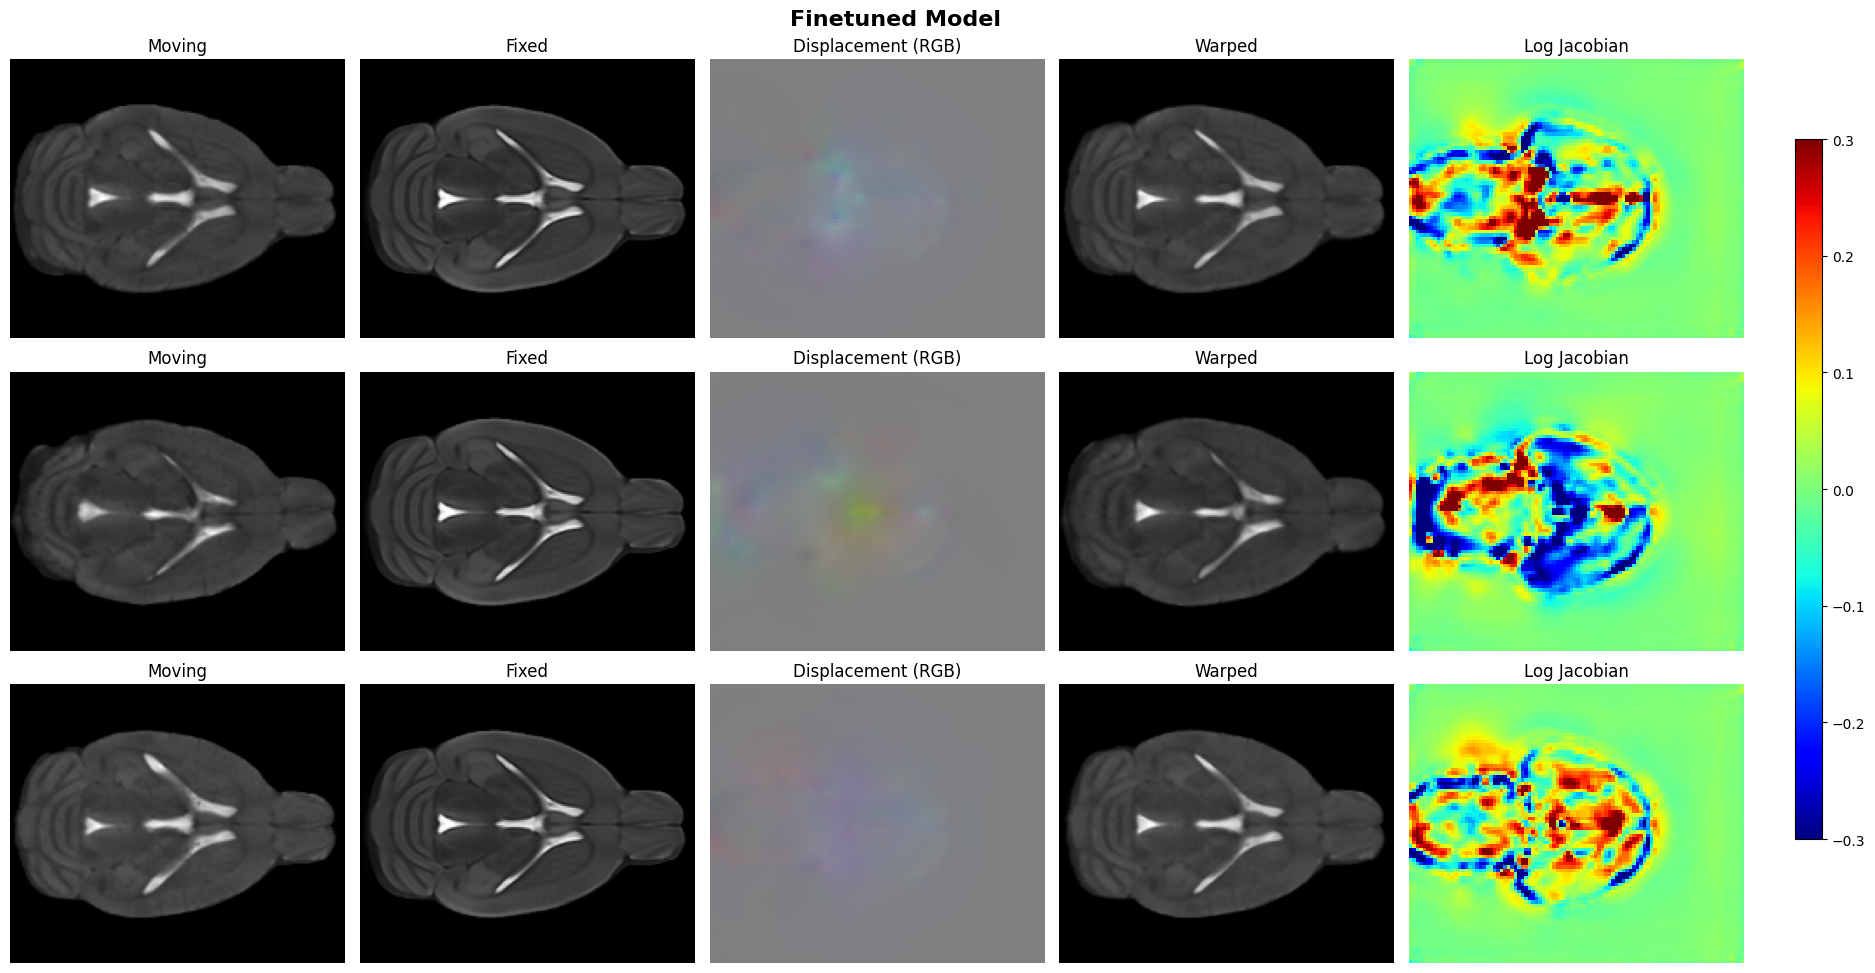

1/1 [==============================] - 0s 233ms/step


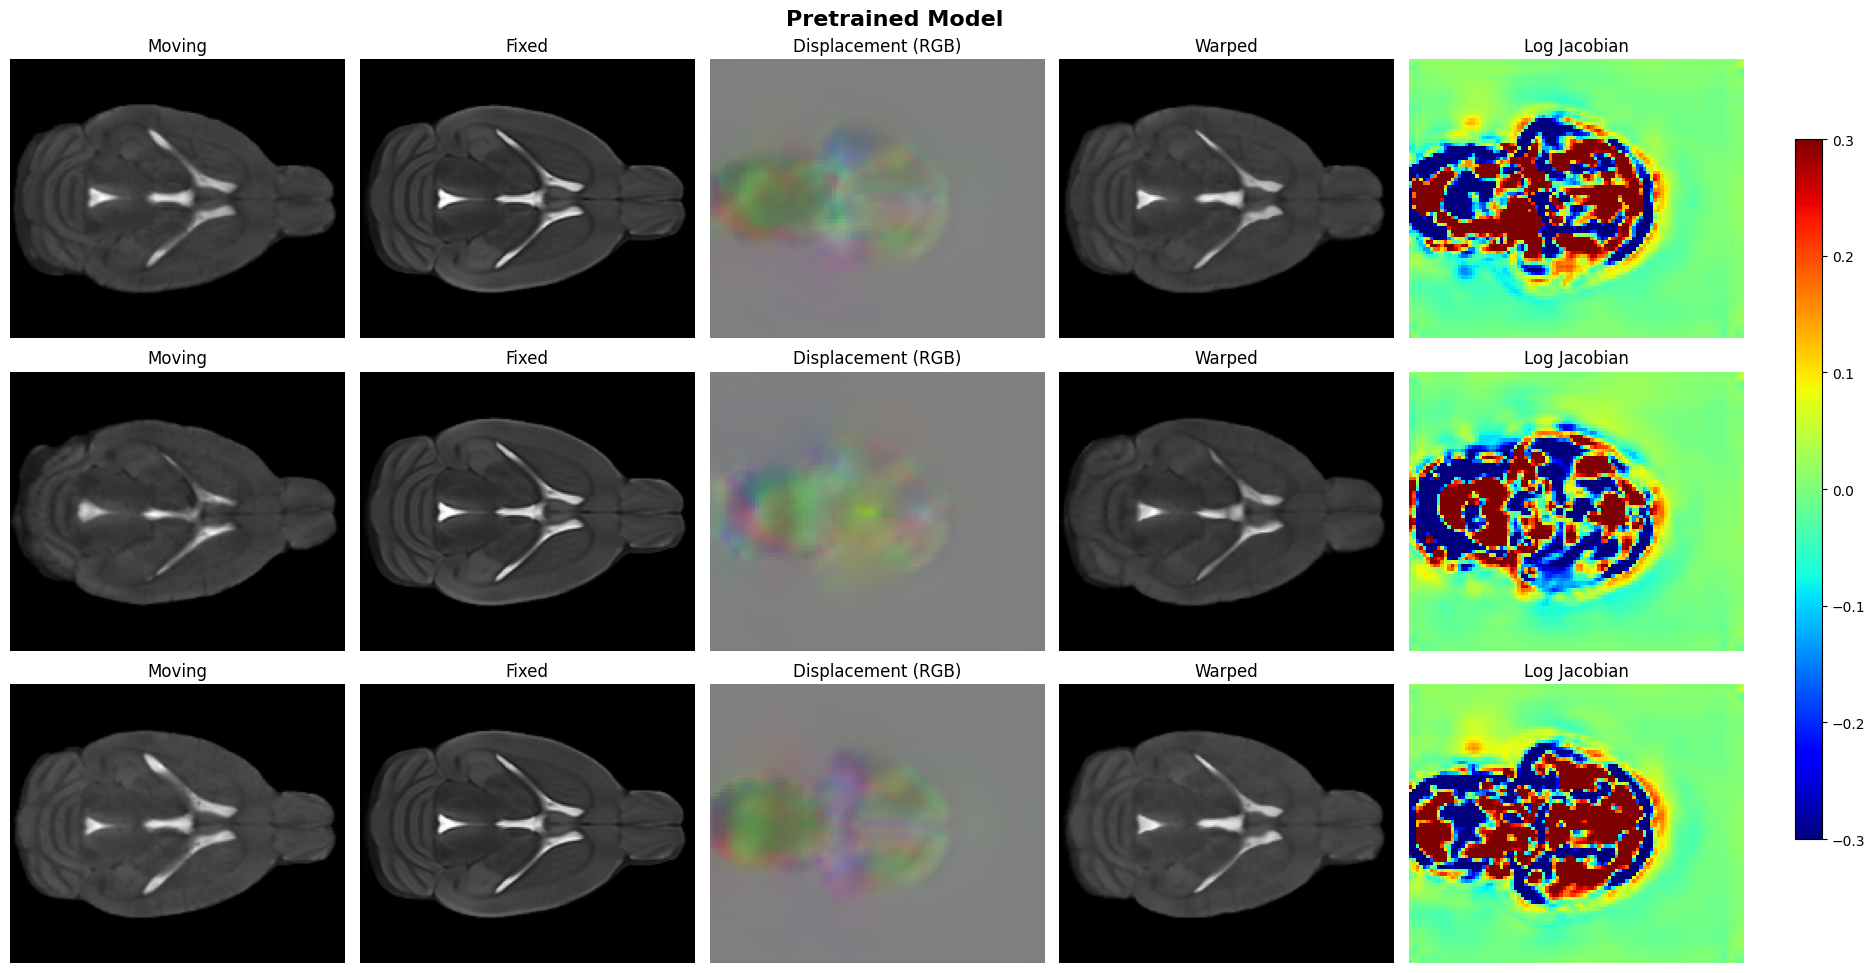

In [ ]:
visualize_model(finetuned, "Finetuned Model", sample_files, fixed_img)
visualize_model(pretrained, "Pretrained Model", sample_files, fixed_img)